## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import pylab 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Change camare calculate to function
def calibration_camare(images, column_point=6, row_point=9):
    '''
    calibration camare by input images (at list 20 images).
    return ret, mtx, dist, rvecs, tvecs
    '''
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((column_point*row_point,3), np.float32)
    objp[:,:2] = np.mgrid[0:row_point,0:column_point].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = []
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
        # Get img_size
        img_size = (img.shape[1], img.shape[0])
        #print(img_size)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()     

    # Calibrate Camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Return
    return ret, mtx, dist

# Make a list of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')

ret, mtx, dist = calibration_camare(calibration_images, 6, 9)

## Apply a distortion correction to raw images

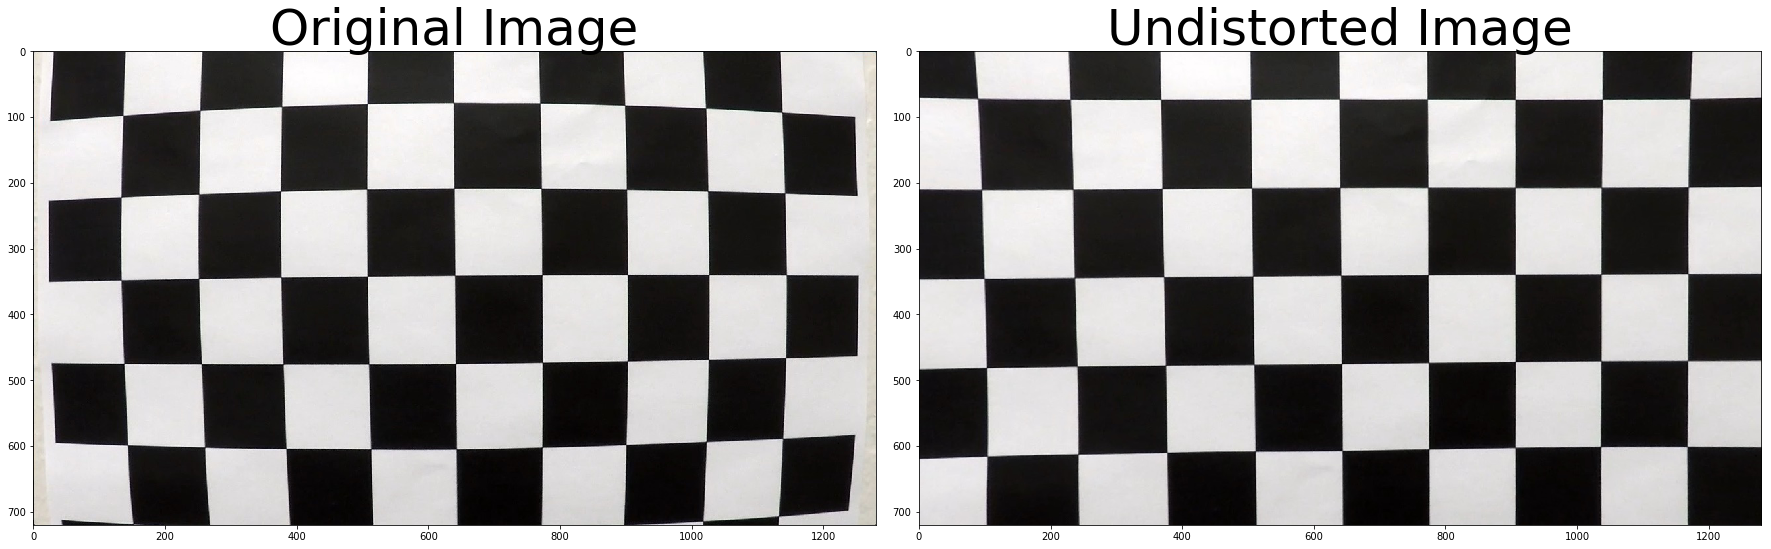

In [2]:
# Create undistort function to output undistort image
def image_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#chess_image = cv2.imread('./camera_cal/calibration1.jpg')
chess_image = mpimg.imread('camera_cal/calibration1.jpg')
undist_chess_image = image_undistort(chess_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chess_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_chess_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.savefig('output_images/undistort_chessboard.jpg')
#f.imsave('output_images/undistort_chessboard.jpg')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color transforms, gradients, etc., to create a thresholded binary image.

6


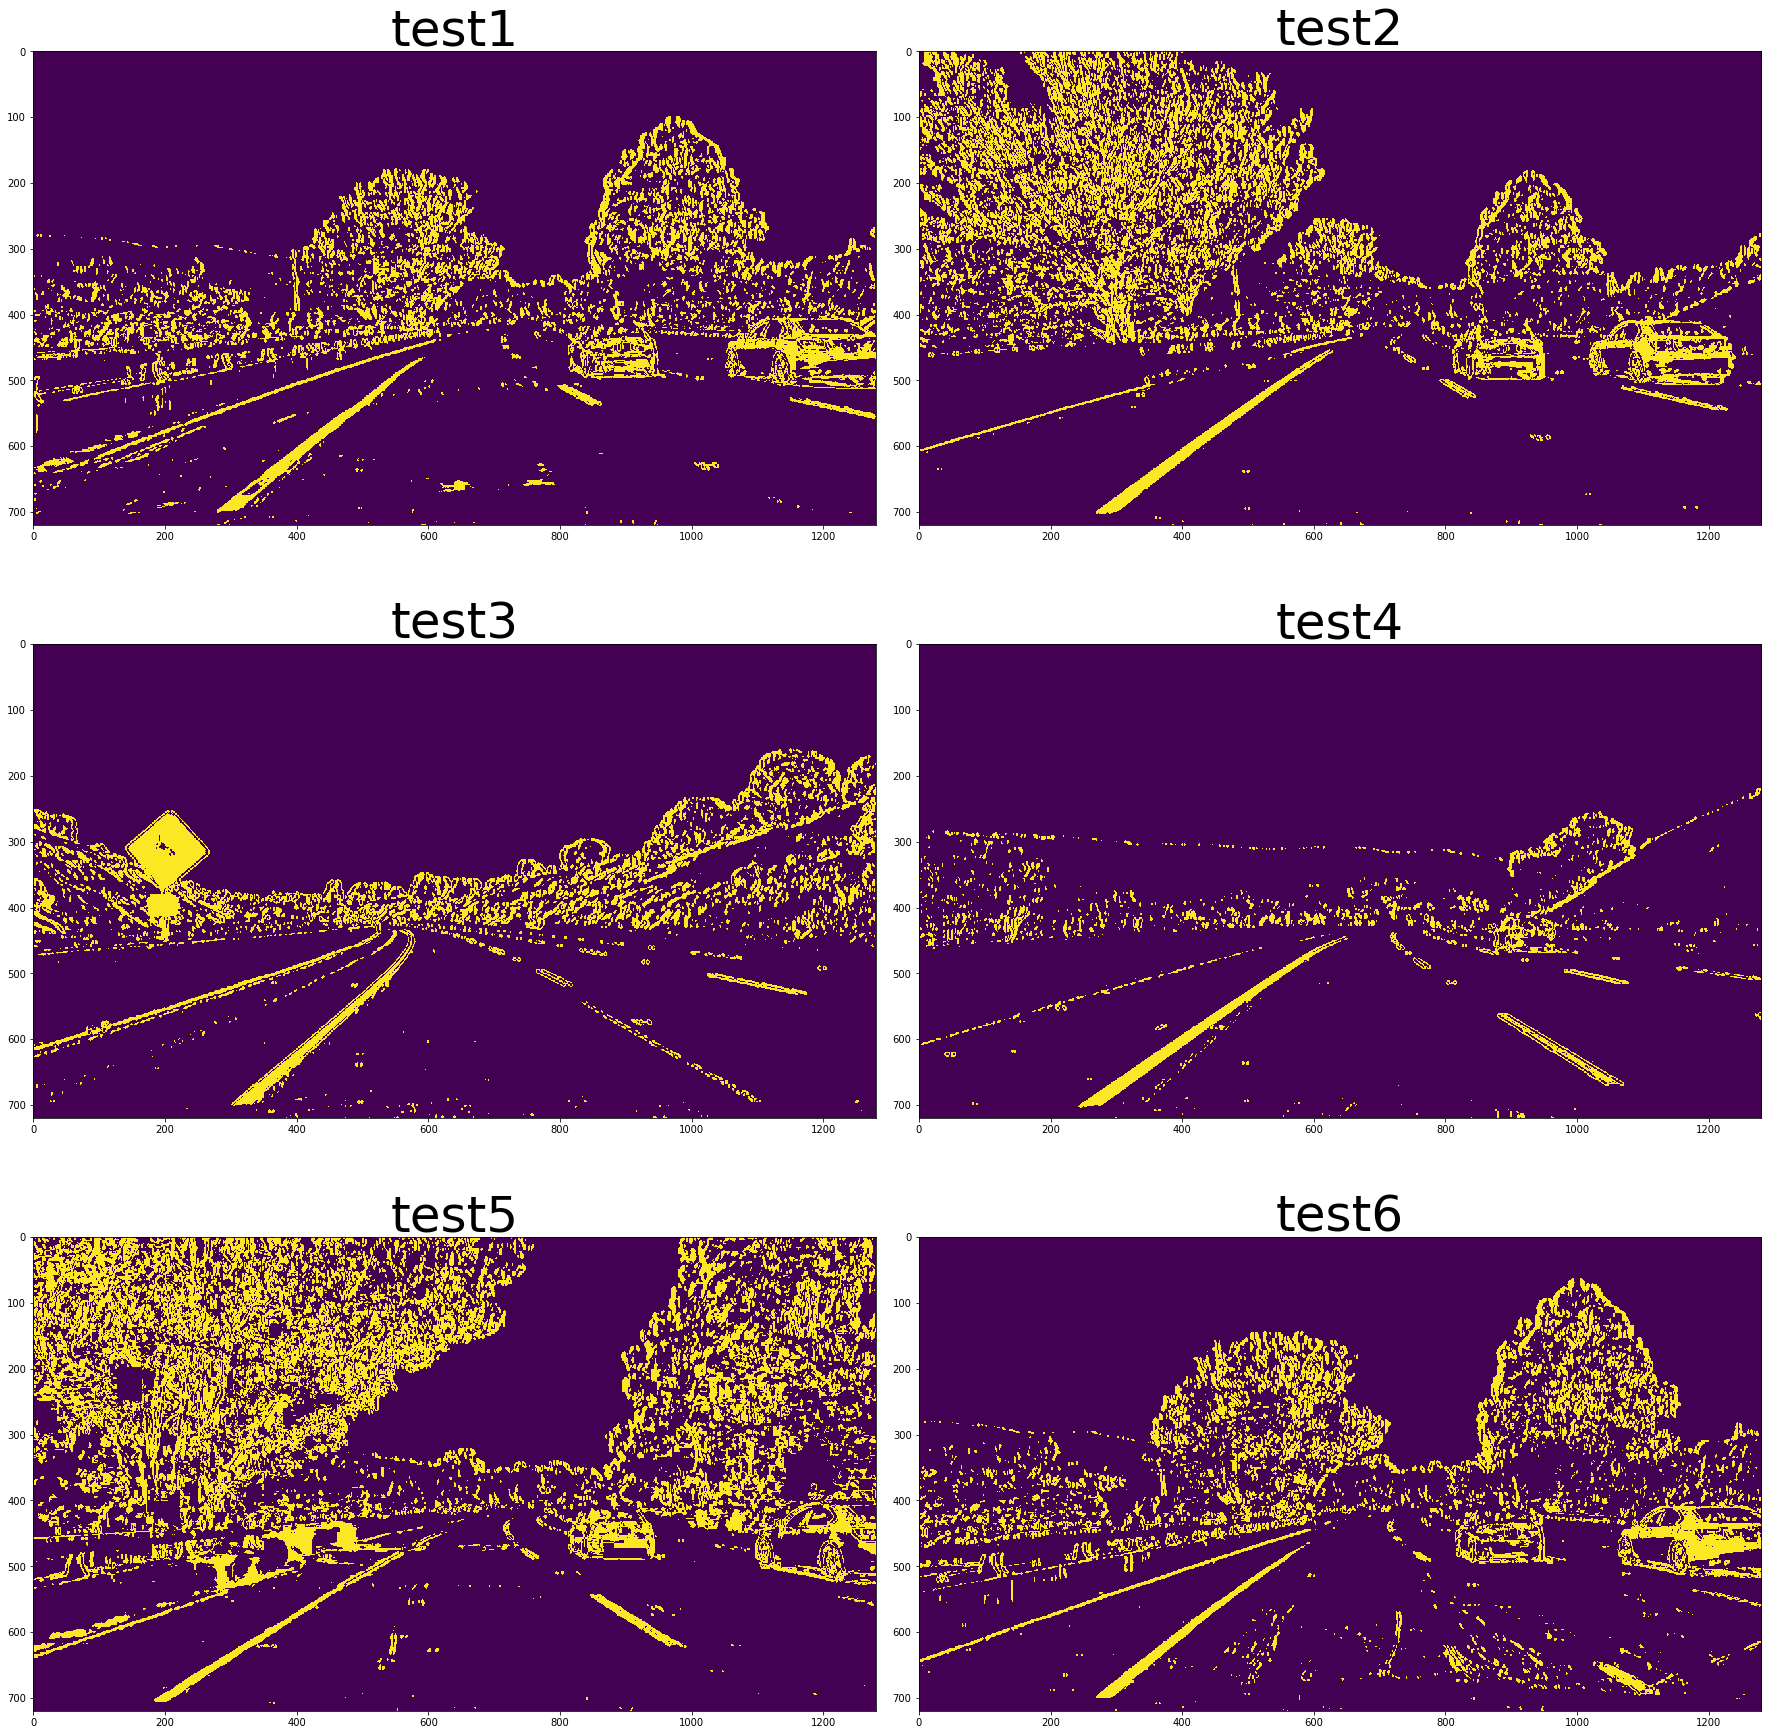

In [3]:
def abs_sobel_thres(gray_image, orient='x', thresh = (0, 255), sobel_kernel=11):
    '''
    Do Sobel transform based on input gray image. 
    Only keep points larger than thresh_min and less than thresh_max and return.    
    
    gray_image: grayed image
    orient: 'x' axis-x, 'y' axis-y
    thresh_min: Keeped value should larger and equal than it
    thresh_max: Keeped value should less than it.
    
    After test on test1.jpg, thresh=(10,70)
    '''
    # Check need convert axis-x or axis-y for Sobel
    if orient == 'x':
        sobel = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Scale absoluted sobel to 8 bits
    abs_sobel=np.absolute(sobel)    
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= thresh[0]) & (scale_sobel < thresh[1])] = 1
    
    return binary_output

def mag_sobel_thres(gray_image, thresh=(0,255), sobel_kernel=11):
    '''
    Return magnitude sobelx and sobely. Also apply thresh and kernel     
    
    After test on test1.jpg, thresh=(20, 70)
    '''
    # Caculate mag_sboel based on sobelx and sobely
    sobelx=cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2+sobely**2)
    
    # Change to uint8
    mag_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # Convert to binary
    binary_output = np.zeros_like(mag_sobel)
    binary_output[(mag_sobel >= thresh[0]) & (mag_sobel < thresh[1])] = 1
    
    return binary_output

def dir_sobel_thres(gray_image, thresh=(0,np.pi/2), sobel_kernel=15):
    '''
    Return direction processed sobel value. Also apply thresh and kernel
        
    After test on test1.jpg, thresh=(0.7, 1.3)
    '''
    # Caculate dir sobel based on sobelx and sobely
    sobelx=cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Convert to binary
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir < thresh[1])] = 1
    
    return binary_output

def combine_sobel_thresh(undist_image, save_name, thresh_comb=([0,255],[0,255],[0., np.pi/2]),
                         kernel_comb=([3,3,3]), debug_print=0):
    '''
    Combine sobelx, sobely, sobel_mag, sobel_dir. Also apply thresh and kernel    
    '''
    gray_image = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
    # Saparate thresh and kernel
    #thresh_xy = thresh[0]
    #thresh_mag = thresh[1]
    #thresh_dir = thresh[2]
    #print(thresh_xy, thresh_mag, thresh_dir)
    #sobel_kernel_xy = sobel_kernel[0]
    #sobel_kernel_mag = sobel_kernel[1]
    #sobel_kernel_dir = sobel_kernel[2]
    #print(sobel_kernel_xy, sobel_kernel_mag, sobel_kernel_dir)
    
    # Get each type sobel value
    sobelx_binary = abs_sobel_thres(gray_image, 'x', thresh=thresh_comb[0], sobel_kernel=kernel_comb[0])
    sobely_binary = abs_sobel_thres(gray_image, 'y', thresh=thresh_comb[0], sobel_kernel=kernel_comb[0])
    mag_sobel_binary = mag_sobel_thres(gray_image, thresh=thresh_comb[1], sobel_kernel=kernel_comb[1])
    dir_sobel_binary = dir_sobel_thres(gray_image, thresh=thresh_comb[2], sobel_kernel=kernel_comb[2]) # still not clear why?

    # Combine
    combine_binary = np.zeros_like(sobelx_binary)
    combine_binary[((sobelx_binary==1)&(sobely_binary==1)) | ((mag_sobel_binary==1)&(dir_sobel_binary==1))]=1
    
    # Draw each binary to check result
    if(debug_print == 1):
        f, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(24, 27))
        f.tight_layout()
        ax1.imshow(sobelx_binary)
        ax1.set_title('Sobel x Binary', fontsize=50)
        ax2.imshow(sobely_binary)
        ax2.set_title('Sobel y Binary', fontsize=50)
        ax3.imshow(mag_sobel_binary)
        ax3.set_title('Magnitude Binary', fontsize=50)
        ax4.imshow(dir_sobel_binary)
        ax4.set_title('Direction Binary', fontsize=50)
        ax5.imshow(combine_binary)
        ax5.set_title('Combine Binary', fontsize=50)
        ax6.imshow(gray_image)
        ax6.set_title('Original Image', fontsize=50)
        plt.savefig(save_name)    
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return combine_binary

def R_channel_thres(image, thresh=(0, 255)):
    '''
    Return binary value of Red channel
    Image should be opened by mpimg.imread, RGB.
    
    After test on test1.jpg, thresh=(220,255)
    '''
    r_channel = image[:,:,0]
    #plt.imshow(r_channel)
    #print(r_channel)
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    
    return r_binary

def S_channel_thres(image, thresh=(0, 255)):
    '''
    Return binary value of  channel.
    Image should be opened by cv2.imread, BGR.
    
    After test on test1.jpg, thresh(130,255)
    '''
    s_channel = (cv2.cvtColor(image, cv2.COLOR_BGR2HLS))[:,:,2]
    #plt.imshow(s_channel)
    #print(r_channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def combine_sChannel_sobelX(image, thresh=([0,255], [0, 255]), sobel_ksize=11):
    '''
    Return combined S-Channel and Sobel-X. Also apply sobel kernel
    Image should be opened by cv2.imread, BGR.
    '''
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx_binary = abs_sobel_thres(gray_image, 'x', thresh[1], sobel_kernel=sobel_ksize)
    #plt.imshow(sobelx_binary)
    
    s_binary = S_channel_thres(image, thresh[0])
    
    combine_binary = np.zeros_like(s_binary)
    combine_binary[(sobelx_binary==1) | (s_binary == 1)] = 1
    
    return combine_binary

# Test sobel
#test_image = cv2.imread('test_images/test1.jpg')
#combin_sobel_saveName = 'output_images/test1_sobel_combine.jpg'
#combin_sobel = combine_sobel_thresh(gray_test_image, combin_sobel_saveName, thresh_comb=([10,70],[20,70],[0.7, 1.3]), kernel_comb=([11,11,15]) )
#plt.imshow(combin_sobel)

# Sobel and S channel combine test
test_images = glob.glob('test_images/test*.jpg')
sobelX_sChannel_binary = []
combine_image_num = 0
for fname in test_images:
    # Read image and get combine binary
    image = mpimg.imread(fname)
    undist_image = image_undistort(image, mtx, dist)
    binary = combine_sChannel_sobelX(undist_image, thresh=([150, 255], [20, 100]))
    sobelX_sChannel_binary.append(binary)
    combine_image_num += 1
print(combine_image_num)
if combine_image_num == 6:
    f, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(24, 27))
    f.tight_layout()
    ax1.imshow(sobelX_sChannel_binary[0])
    ax1.set_title('test1', fontsize=50)
    ax2.imshow(sobelX_sChannel_binary[1])
    ax2.set_title('test2', fontsize=50)
    ax3.imshow(sobelX_sChannel_binary[2])
    ax3.set_title('test3', fontsize=50)
    ax4.imshow(sobelX_sChannel_binary[3])
    ax4.set_title('test4', fontsize=50)
    ax5.imshow(sobelX_sChannel_binary[4])
    ax5.set_title('test5', fontsize=50)
    ax6.imshow(sobelX_sChannel_binary[5])
    ax6.set_title('test6', fontsize=50)
    plt.savefig('output_images/Combine_sobelX_sChannel.jpg')    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a perspective transform to rectify binary image ("birds-eye view").

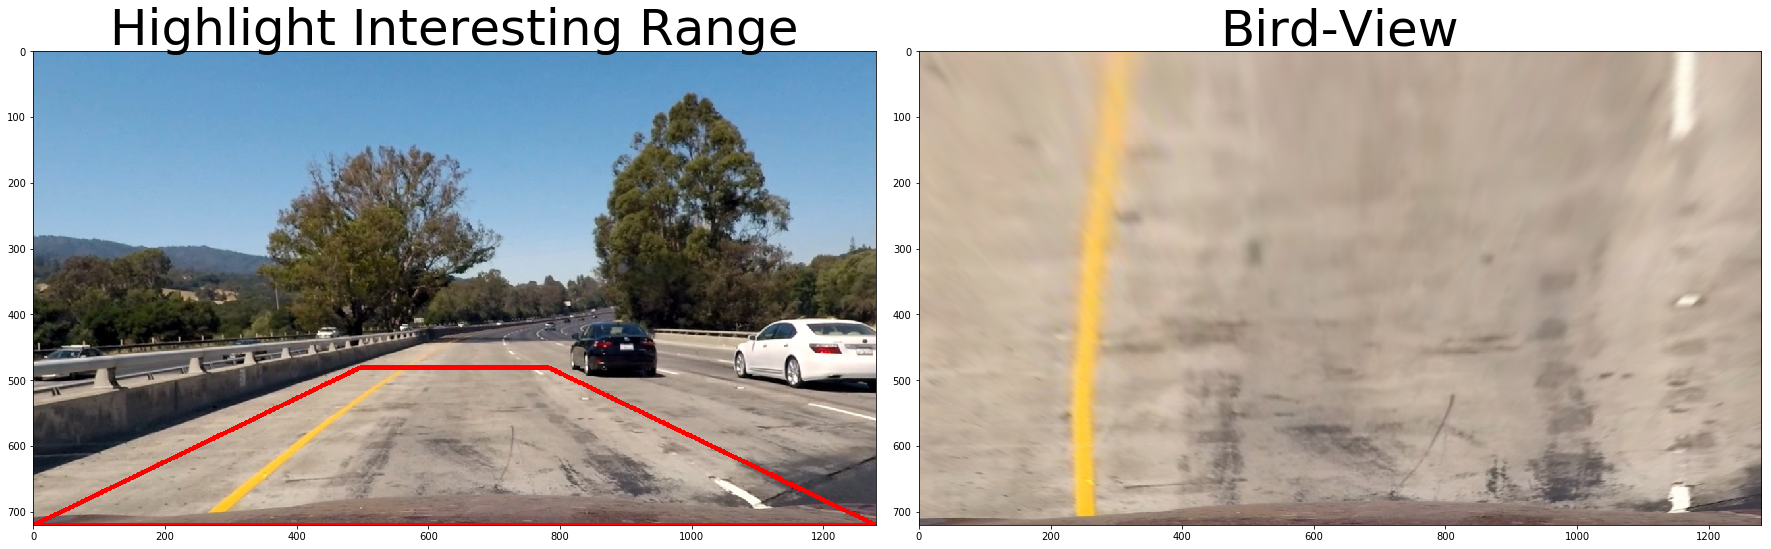

In [16]:
def draw_retangle_of_interesting(image, retangle, color=[255, 0, 0], thickness=6):
    # Draw Lines of retangle
    #print("retangle",retangle, "retangle[0,0]", retangle[0,0], retangle[0,1])
    cv2.line(image, (retangle[0, 0], retangle[0, 1]), 
             (retangle[1, 0], retangle[1, 1]), color, thickness)
    cv2.line(image, (retangle[1, 0], retangle[1, 1]), 
             (retangle[2, 0], retangle[2, 1]), color, thickness)
    cv2.line(image, (retangle[2, 0], retangle[2, 1]), 
             (retangle[3, 0], retangle[3, 1]), color, thickness)
    cv2.line(image, (retangle[3, 0], retangle[3, 1]), 
             (retangle[0, 0], retangle[0, 1]), color, thickness)
    return image

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_interesting_range_of_image(img, center_point, miniY):
    '''
    Return interesting range of a image. The interesting range is identified by center_point and miniY.
    miniY must larger than axis-y of center_point
    vertices point order: leftBottom, leftTop, rightTop, rightBottom
    '''    
    if miniY < center_point[1]:
        return False, np.array([[0]], dtype=np.int32)
    imshape = img.shape
    
    # set interesting region   
    maxY = imshape[0]    
    left_slope = (center_point[1] - imshape[0])/(center_point[0] - 0)
    leftB = center_point[1] - (left_slope * center_point[0])
    right_slope = (imshape[0] - center_point[1])/(imshape[1] - center_point[0])
    rightB = center_point[1] - (right_slope * center_point[0])
    
    left_topx = np.int32((miniY - leftB)/left_slope)
    right_topx = np.int32((miniY - rightB)/right_slope)
    #print(left_topx, right_topx)
    vertices = np.array([[(0,maxY),(left_topx, miniY), (right_topx, miniY), (imshape[1], maxY)]], dtype=np.int32)
    
    return True, vertices

def find_center_point(image):
    center_point = np.uint32([image.shape[1]/2, (image.shape[0]/7)*4])
    return center_point
def find_minimal_y(iamge):
    miniY = np.uint32((image.shape[0]/3)*2)
    return miniY

def cvt_interesting_range_2_topview_retangle(imshape, vertices):
    vertices_2d = vertices[0]    
    #print("2d vertices", vertices_2d)
    topviewBottomLeftX = np.int32((imshape[1]/10)*2)
    topviewBottomRightX = imshape[1] - topviewBottomLeftX   
    
    eyeviewTopXs = []
    vertices_hs = np.dstack(vertices_2d)    
    #print("vertices_hs[0]",vertices_hs[0,0])
    for x in vertices_hs[0,0]:
        if(x > 0) & (x<imshape[1]):
            eyeviewTopXs.append(x)   
    #print("eyeviewTopXs", eyeviewTopXs)
    eyeviewTopLineLen = np.absolute(eyeviewTopXs[0]- eyeviewTopXs[1])
    #print("eyeviewTopLineLen", eyeviewTopLineLen)
    
    eyeviewTopLeftX = vertices_2d[1,0] + np.int32((eyeviewTopLineLen/10)*2)
    eyeviewTopRightX = vertices_2d[2, 0] - np.int32((eyeviewTopLineLen/10)*2)
    eyeviewBottomLeftX = topviewBottomLeftX
    eyeviewBottomRightX = topviewBottomRightX
    #print("vertices_2d[0,1]",vertices_2d[0,1], "vertices_2d", vertices_2d)
    #print("eyeviewTopLeftX", eyeviewTopLeftX, "eyeviewTopRightX", eyeviewTopRightX )
    
    eyeviewVertices = np.array([(eyeviewBottomLeftX, imshape[0]), (eyeviewTopLeftX, vertices_2d[1,1]),
                               (eyeviewTopRightX, vertices_2d[2,1]), (eyeviewBottomRightX, imshape[0])])
    topviewVertices = np.array([(topviewBottomLeftX, imshape[0]), (topviewBottomLeftX, 0),
                               (topviewBottomRightX, 0), (topviewBottomRightX, imshape[0])])
    
    return eyeviewVertices, topviewVertices

def bird_view_transform(img, original_retangle, target_retangle):
    '''
    Generate bird-view image    
    '''
    # Swrap image
    src = np.float32([original_retangle[0], original_retangle[1], original_retangle[2], original_retangle[3]])
    dst = np.float32([target_retangle[0], target_retangle[1], target_retangle[2], target_retangle[3]])
    tran_matrix = cv2.getPerspectiveTransform(src, dst)
    birdview_image = cv2.warpPerspective(img, tran_matrix, 
                                         (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return birdview_image

def test_bird_view_with_interesting_rang(drawInterestingRange):
    testImage = mpimg.imread('test_images/test1.jpg')

    undistImage = cv2.undistort(testImage, mtx, dist, None, mtx)
    imageShape = undistImage.shape
    
    centerPoint = find_center_point(undistImage)
    miniY = find_minimal_y(undistImage)
    #print(centerPoint, miniY)
    
    ret, vertices = find_interesting_range_of_image(undistImage, centerPoint, miniY)
    if ret == True:
        #print("vertices", vertices)
        masked_edges = region_of_interest(undistImage, vertices)
        #plt.imshow(masked_edges)
    else: 
        print("Center point and miniY mismatch")

    eyeviewVertices, birdViewVertices = cvt_interesting_range_2_topview_retangle(undistImage.shape, vertices)
    #print("eyeviewVertices",eyeviewVertices, "birdViewVertices",birdViewVertices)
    
    birdViewImage = bird_view_transform(undistImage, eyeviewVertices, birdViewVertices)
    #plt.imshow(birdViewImage)

    if drawInterestingRange == True:
        undistImage = draw_retangle_of_interesting(undistImage, vertices[0])
        #birdViewImage = draw_retangle_of_interesting(birdViewImage, birdViewVertices)    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistImage)
    ax1.set_title('Highlight Interesting Range', fontsize=50)
    ax2.imshow(birdViewImage)
    ax2.set_title('Bird-View', fontsize=50)
    plt.savefig('output_images/bird-eyes-view.jpg')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_bird_view_with_interesting_rang(True)

## Detect lane pixels and fit to find the lane boundary.

In [ ]:
def 

## Determine the curvature of the lane and vehicle position with respect to center.

## Warp the detected lane boundaries back onto the original image.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.